In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [2]:
df = pd.read_csv('1_processed_loan_data.csv')

In [3]:
df.head(5)

,Loan_Type,Overdue_Status,Action_Taken,Officer_Assigned,Division,Loan_Amount,Jan_Recovery,Feb_Recovery,Mar_Recovery,Apr_Recovery,May_Recovery,Jun_Recovery,Jul_Recovery,Aug_Recovery,Sep_Recovery,Oct_Recovery,Nov_Recovery,Dec_Recovery,Outstanding_Balance
0,2024_Maha_season,No,No,No,Talawakelle,50000,0,40000,0,0,0,10000,0,0,0,0,0,0,0
1,2024_Maha_season,No,No,No,Talawakelle,50000,0,0,21028,0,14486,0,0,0,14486,0,0,0,0
2,2024_Maha_season,No,No,Yes,Thonigala,20000,0,0,0,0,20000,0,0,0,0,0,0,0,0
3,2024_Maha_season,No,No,Yes,Thonigala,25000,0,0,0,0,25000,0,0,0,0,0,0,0,0
4,2024_Maha_season,No,No,Yes,Periyakulam,100000,0,0,0,0,0,0,0,0,40000,0,50000,10000,0


In [4]:
# 1. Data Type Validation
# Why: Ensuring numerical columns are correctly interpreted for mathematical modeling.
# Result: Verification that financial columns are Int64/Float64.
print("--- Data Types ---")
print(df.dtypes)

--- Data Types ---
Loan_Type              object
Overdue_Status         object
Action_Taken           object
Officer_Assigned       object
Division               object
Loan_Amount             int64
Jan_Recovery            int64
Feb_Recovery            int64
Mar_Recovery            int64
Apr_Recovery            int64
May_Recovery            int64
Jun_Recovery            int64
Jul_Recovery            int64
Aug_Recovery            int64
Sep_Recovery            int64
Oct_Recovery            int64
Nov_Recovery            int64
Dec_Recovery            int64
Outstanding_Balance     int64
dtype: object


In [5]:
# 2. Descriptive Statistics
# Why: To understand the range, mean, and spread of our financial data.
# Focus on key metrics: Loan_Amount and Outstanding_Balance.
# Result: Statistical summary exported for the report.
key_metrics = df[['Loan_Amount', 'Outstanding_Balance']].describe()
print("\n--- Key Financial Metrics ---")
print(key_metrics)


--- Key Financial Metrics ---
         Loan_Amount  Outstanding_Balance
count     296.000000           296.000000
mean    90775.337838         14686.584459
std     20233.242488         31718.635692
min     18000.000000             0.000000
25%    100000.000000             0.000000
50%    100000.000000             0.000000
75%    100000.000000             0.000000
max    111500.000000        100000.000000


In [6]:
# 3. Missing Value Audit
# Why: To confirm that our preprocessing pipeline has addressed all null values.
# Result: Verification of zero missing values across all 19 columns.
missing_values = df.isnull().sum()
print("\n--- Missing Value Audit ---")
print(missing_values)


--- Missing Value Audit ---
Loan_Type              0
Overdue_Status         0
Action_Taken           0
Officer_Assigned       0
Division               0
Loan_Amount            0
Jan_Recovery           0
Feb_Recovery           0
Mar_Recovery           0
Apr_Recovery           0
May_Recovery           0
Jun_Recovery           0
Jul_Recovery           0
Aug_Recovery           0
Sep_Recovery           0
Oct_Recovery           0
Nov_Recovery           0
Dec_Recovery           0
Outstanding_Balance    0
dtype: int64


# Target and Distribution Visualizations

/tmp/ipython-input-1225868148.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Overdue_Status', palette='viridis')


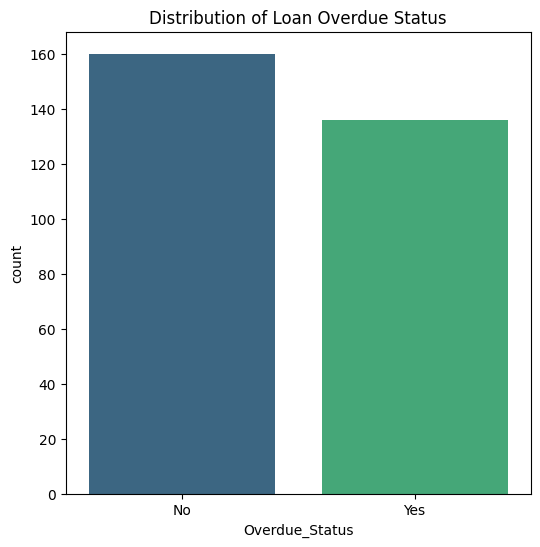

In [7]:
# --- Process 1.2: Target Distribution ---
# Why: To check for class imbalance for
plt.figure(figsize=(6, 6))
sns.countplot(data=df, x='Overdue_Status', palette='viridis')
plt.title('Distribution of Loan Overdue Status')
plt.savefig('target_distribution.png')

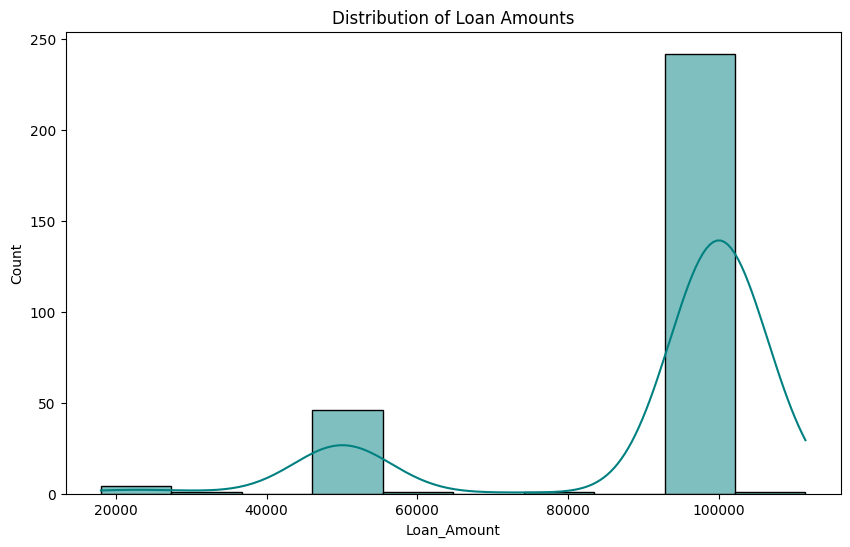

In [8]:
# --- Process 1.3: Numerical Distribution ---
# Why: To understand feature spread and detect outliers
# Histplot for Loan Amount
plt.figure(figsize=(10, 6))
sns.histplot(df['Loan_Amount'], kde=True, color='teal')
plt.title('Distribution of Loan Amounts')
plt.savefig('loan_amount_hist.png')

/tmp/ipython-input-2411373590.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Overdue_Status', y='Outstanding_Balance', palette='magma')


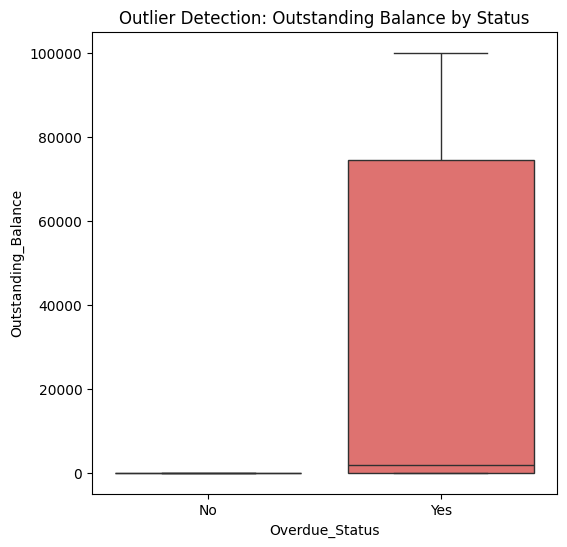

In [9]:
# Boxplot for Outlier Detection in Outstanding Balance
plt.figure(figsize=(6, 6))
sns.boxplot(data=df, x='Overdue_Status', y='Outstanding_Balance', palette='magma')
plt.title('Outlier Detection: Outstanding Balance by Status')
plt.savefig('outstanding_balance_boxplot.png')

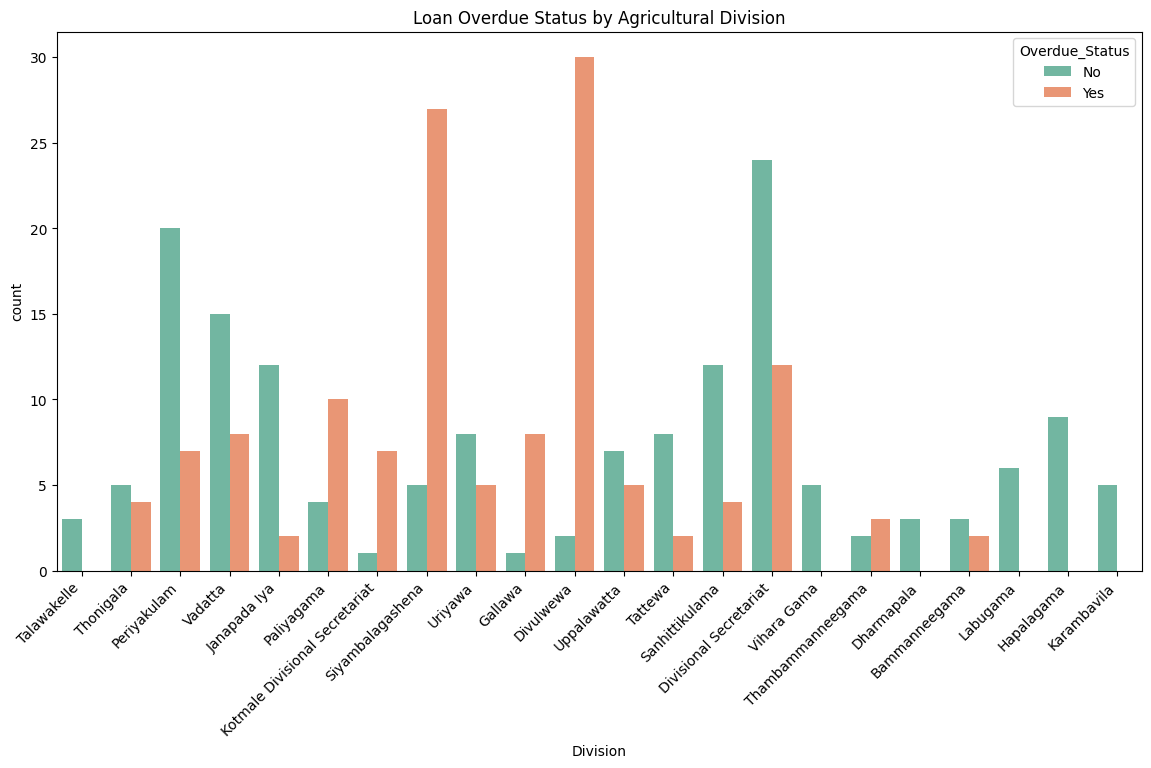

In [10]:
# 1. Division vs Overdue Status
# Why: To identify geographical risk pockets.
plt.figure(figsize=(14, 7))
sns.countplot(data=df, x='Division', hue='Overdue_Status', palette='Set2')
plt.title('Loan Overdue Status by Agricultural Division')
plt.xticks(rotation=45, ha='right')
plt.savefig('division_risk_analysis.png')

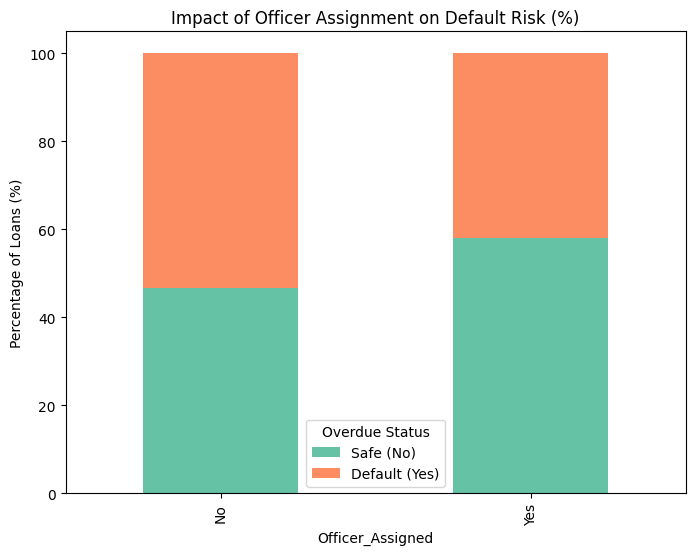

In [11]:
# 2. Officer Assigned vs Overdue Status (Percentage based)
# Why: To objectively measure if officer intervention improves repayment.
officer_risk = pd.crosstab(df['Officer_Assigned'], df['Overdue_Status'], normalize='index') * 100
officer_risk.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'], figsize=(8, 6))
plt.title('Impact of Officer Assignment on Default Risk (%)')
plt.ylabel('Percentage of Loans (%)')
plt.legend(title='Overdue Status', labels=['Safe (No)', 'Default (Yes)'])
plt.savefig('officer_assignment_impact.png')

# Multicollinearity & Correlation Analysis

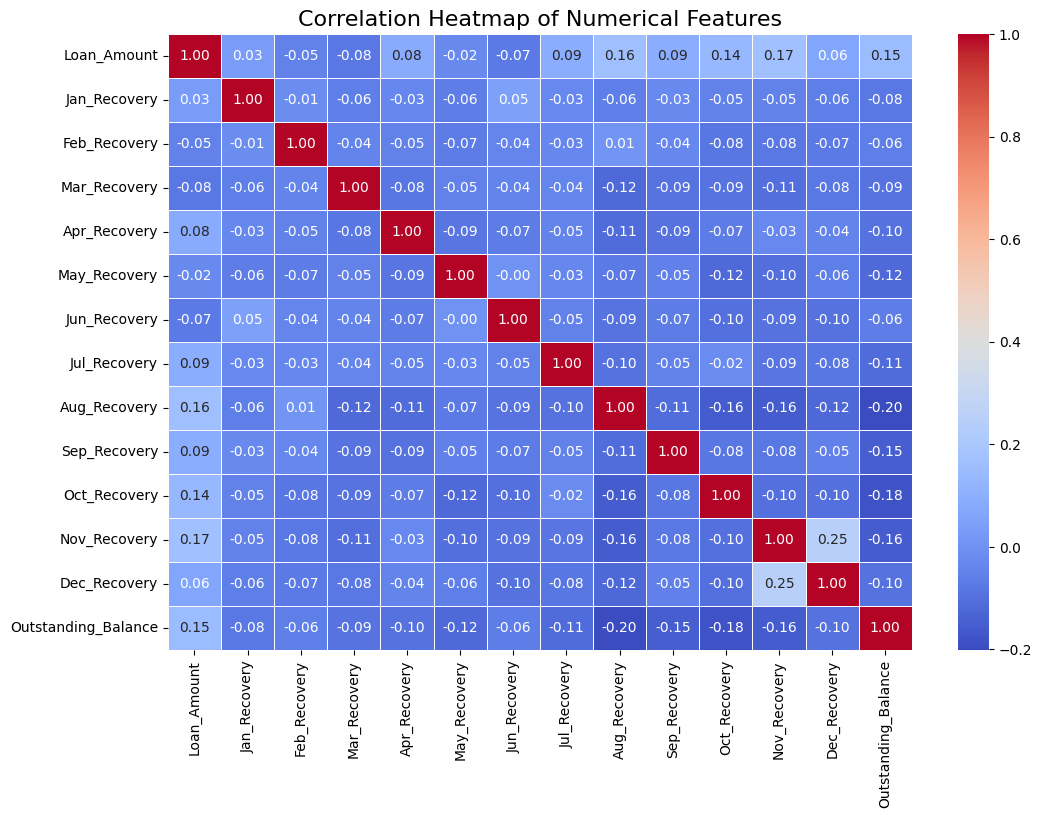

In [12]:
# Select only numerical columns (Financial data)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate Correlation Matrix
corr_matrix = df[numerical_cols].corr()

# Create Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.savefig('correlation_heatmap.png')

Final EDA visualizations generated: recovery_trend.png, target_pie_chart.png


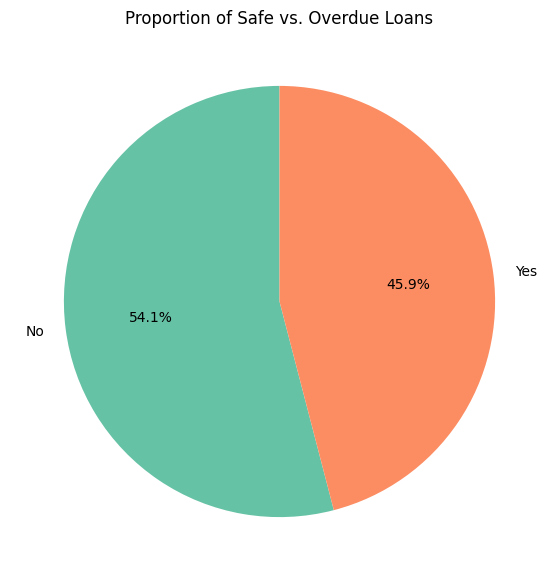

In [13]:
# --- Process 1.6: Recovery Trend Analysis ---
# Why: To understand the seasonality of repayments in Sri Lankan agriculture.


months = ['Jan_Recovery', 'Feb_Recovery', 'Mar_Recovery', 'Apr_Recovery',
          'May_Recovery', 'Jun_Recovery', 'Jul_Recovery', 'Aug_Recovery',
          'Sep_Recovery', 'Oct_Recovery', 'Nov_Recovery', 'Dec_Recovery']

          # --- Target Proportion (Pie Chart) ---
# Why: A quick visual summary of the class distribution for the report.
plt.figure(figsize=(7, 7))
df['Overdue_Status'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66c2a5', '#fc8d62'], startangle=90)
plt.title('Proportion of Safe vs. Overdue Loans')
plt.ylabel('') # Remove y-label for aesthetics
plt.savefig('target_pie_chart.png')

print("Final EDA visualizations generated: recovery_trend.png, target_pie_chart.png")

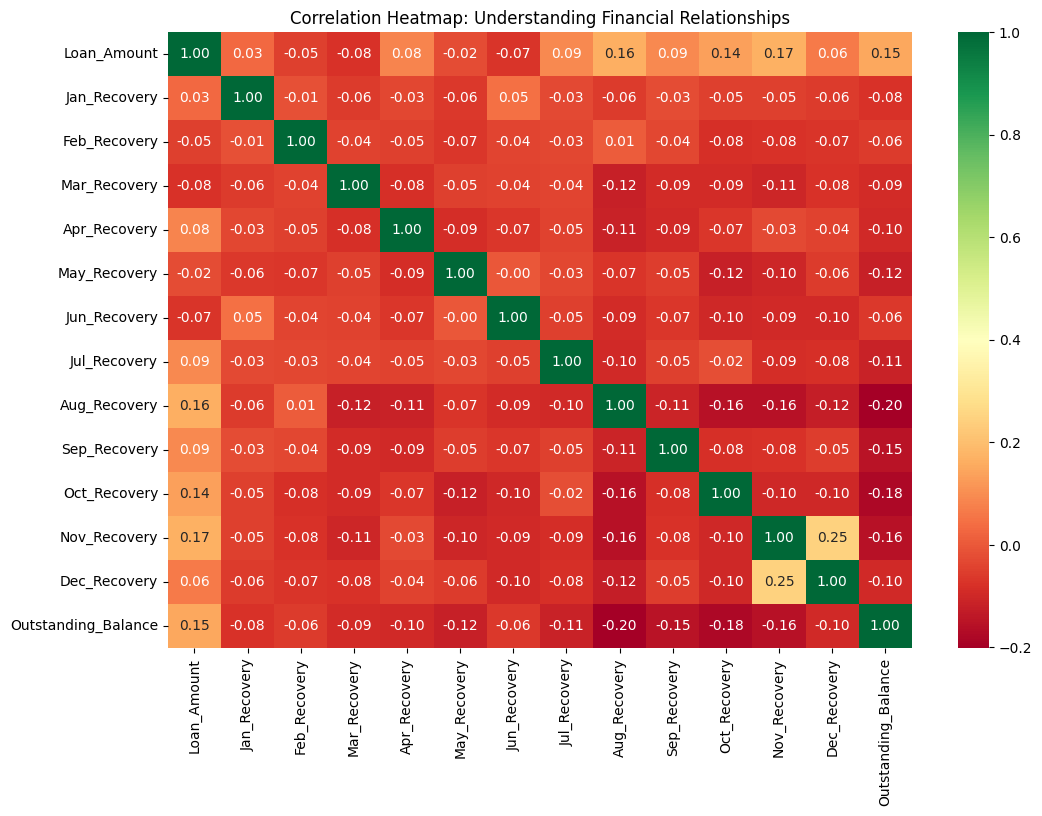

In [14]:
plt.figure(figsize=(12, 8))
# Calculating correlation only for numerical financial data
corr_matrix = df.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt='.2f')
plt.savefig('correlation_financial_data.png')
plt.title("Correlation Heatmap: Understanding Financial Relationships")
plt.show()

## Summary of EDA

We did this step to transform raw data into "Analytical Intelligence." Before building the CatBoost model, we needed to ensure the data was clean, check for class imbalances (Safe vs. Overdue), and identify which features (like Division or Officer presence) actually drive loan defaults

We did this step to transform raw data into "Analytical Intelligence." Before building the CatBoost model, we needed to ensure the data was clean, check for class imbalances (Safe vs. Overdue), and identify which features (like Division or Officer presence) actually drive loan defaults

We did this step for Data Validation and Insight Discovery, and it resulted in a clean, English-translated, and statistically understood dataset. We now have clear evidence that features like Division, Officer_Assigned, and Monthly_Recoveries are high-value predictors, and our dataset is robust enough to move to the model training phase.


# Phase 2: Feature Engineering

1.   TASK 2.1: AGGREGATED FINANCIAL METRICS
2.   TASK 2.2: NORMALIZED RISK RATIOS
3.   TASK 2.3: TARGET VARIABLE TRANSFORMATION
4.   TASK 2.4: FEATURE SELECTION & DROPPING IRRELEVANT COLUMNS
5.   TASK 2.5: TRAIN-TEST SPLIT WITH STRATIFICATION
      

In [15]:
# --- TASK 2.1: AGGREGATED FINANCIAL METRICS ---
# Why: Summing monthly data into a single 'Total Recovery' feature provides
# a clearer picture of historical payment behavior than looking at individual months.
months = ['Jan_Recovery', 'Feb_Recovery', 'Mar_Recovery', 'Apr_Recovery',
          'May_Recovery', 'Jun_Recovery', 'Jul_Recovery', 'Aug_Recovery',
          'Sep_Recovery', 'Oct_Recovery', 'Nov_Recovery', 'Dec_Recovery']

df['Total_Recovery'] = df[months].sum(axis=1)
df[['Total_Recovery']].head(10)
# df.head()

,Total_Recovery
0,50000
1,50000
2,20000
3,25000
4,100000
5,100000
6,100000
7,50000
8,84286
9,100000


In [16]:
# --- TASK 2.2: NORMALIZED RISK RATIOS ---
# Why: Ratios (0.0 to 1.0) allow the model to compare small and large loans fairly.
# Repayment_Ratio: Percentage of the loan already paid back.
# Debt_Ratio: Percentage of the loan still outstanding.
df['Repayment_Ratio'] = df['Total_Recovery'] / df['Loan_Amount']
df['Debt_Ratio'] = df['Outstanding_Balance'] / df['Loan_Amount']
df[['Loan_Amount', 'Total_Recovery', 'Repayment_Ratio', 'Debt_Ratio']].head()

,Loan_Amount,Total_Recovery,Repayment_Ratio,Debt_Ratio
0,50000,50000,1.0,0.0
1,50000,50000,1.0,0.0
2,20000,20000,1.0,0.0
3,25000,25000,1.0,0.0
4,100000,100000,1.0,0.0


In [17]:
# --- TASK 2.3: TARGET VARIABLE TRANSFORMATION ---
# Why: Mapping 'Yes'/'No' labels to numeric 1/0 for ML compatibility.
# Mapping text to 0 and 1
# Why: Models require numeric targets.

df['Overdue_Status'] = df['Overdue_Status'].map({'No': 0, 'Yes': 1})
print(df['Overdue_Status'].value_counts())

Overdue_Status
0    160
1    136
Name: count, dtype: int64


In [18]:
# --- TASK 2.4: FEATURE SELECTION & DROPPING IRRELEVANT COLUMNS ---
# Why: Removing individual months to reduce noise (multicollinearity) and
# dropping administrative columns like 'Action_Taken' which are not predictors.
cols_to_drop = months + ['Action_Taken']
df_engineered = df.drop(columns=cols_to_drop)
# print("Remaining Columns:", df_engineered.columns.tolist())

df_engineered.head()


,Loan_Type,Overdue_Status,Officer_Assigned,Division,Loan_Amount,Outstanding_Balance,Total_Recovery,Repayment_Ratio,Debt_Ratio
0,2024_Maha_season,0,No,Talawakelle,50000,0,50000,1.0,0.0
1,2024_Maha_season,0,No,Talawakelle,50000,0,50000,1.0,0.0
2,2024_Maha_season,0,Yes,Thonigala,20000,0,20000,1.0,0.0
3,2024_Maha_season,0,Yes,Thonigala,25000,0,25000,1.0,0.0
4,2024_Maha_season,0,Yes,Periyakulam,100000,0,100000,1.0,0.0


In [19]:
# --- TASK 2.5: TRAIN-TEST SPLIT WITH STRATIFICATION ---
# Why: Splitting data (80% Train / 20% Test) while maintaining the
# same 'Default' ratio in both sets to prevent model bias.
X = df_engineered.drop(columns=['Overdue_Status'])
y = df_engineered['Overdue_Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Feature Engineering Complete. Final Feature Count: {X.shape[1]}")
df_engineered.head()

Feature Engineering Complete. Final Feature Count: 8


,Loan_Type,Overdue_Status,Officer_Assigned,Division,Loan_Amount,Outstanding_Balance,Total_Recovery,Repayment_Ratio,Debt_Ratio
0,2024_Maha_season,0,No,Talawakelle,50000,0,50000,1.0,0.0
1,2024_Maha_season,0,No,Talawakelle,50000,0,50000,1.0,0.0
2,2024_Maha_season,0,Yes,Thonigala,20000,0,20000,1.0,0.0
3,2024_Maha_season,0,Yes,Thonigala,25000,0,25000,1.0,0.0
4,2024_Maha_season,0,Yes,Periyakulam,100000,0,100000,1.0,0.0


# Phase 3: Model Development

1. Algorithm Selection & Justification
2. Label Encoding for Categorical Data
3. Model Initialization & Hyperparameters
4. Model Training
5. Performance Evaluation


In [20]:
# 2. ENCODE CATEGORICAL FEATURES (Task 3.2)
# Why: HistGradientBoosting requires numeric inputs for categories.

cat_cols = ['Loan_Type', 'Officer_Assigned', 'Division']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) # Handles potential new categories in test set

# Fit encoder on training data and transform both train and test sets
X_train[cat_cols] = encoder.fit_transform(X_train[cat_cols])
X_test[cat_cols] = encoder.transform(X_test[cat_cols])

# Explicitly drop 'Action_Taken' if it's still present (due to prior inconsistent state)
# It was intended to be dropped in TASK 2.4, but the error indicates it might still be there.

if 'Action_Taken' in X_train.columns:
    X_train = X_train.drop(columns=['Action_Taken'])
    X_test = X_test.drop(columns=['Action_Taken'])

print("Categorical features encoded and irrelevant columns handled in X_train and X_test.")

Categorical features encoded and irrelevant columns handled in X_train and X_test.


In [21]:
# 4. INITIALIZE & TRAIN (Task 3.3 & 3.4)
# Why: This is our 'New' Advanced Algorithm.
model = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=42)

In [22]:
# 5. EVALUATE (Task 3.5)
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.85
F1-Score: 0.82

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87        32
           1       0.91      0.75      0.82        28

    accuracy                           0.85        60
   macro avg       0.86      0.84      0.85        60
weighted avg       0.86      0.85      0.85        60



Phase 4: Explainable AI (XAI)

1.   SHAP (SHapley Additive exPlanations)
2.   Individual Case Explanation (Local Interpretability)
3.   Business Insight Report


In [23]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap
shap.initjs()

High Risk Case Analysis: Debt Ratio is 0.0


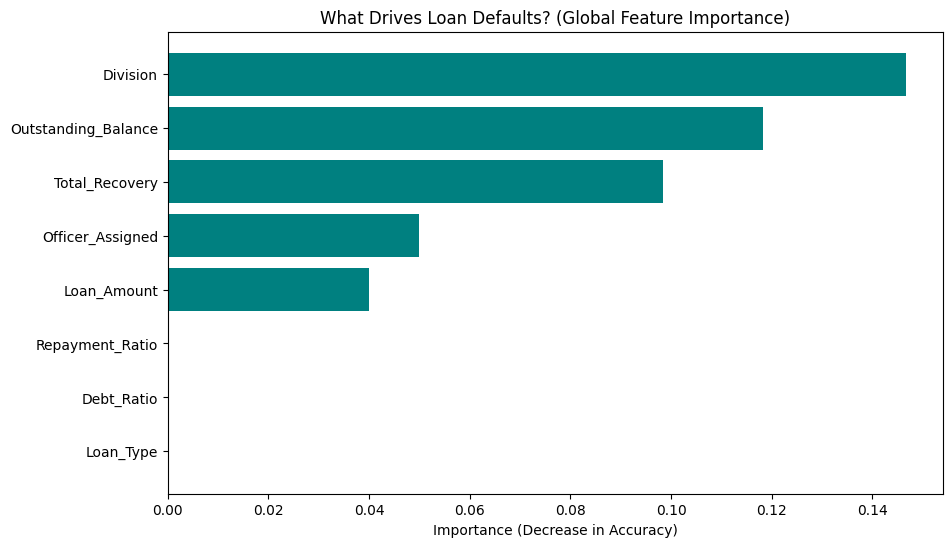

In [24]:
# 1. Calculate Permutation Importance
# Why: To see which features truly 'drive' the model's decisions.
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# 2. Visualizing Global Importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], color='teal')
plt.xlabel("Importance (Decrease in Accuracy)")
plt.title("What Drives Loan Defaults? (Global Feature Importance)")
plt.savefig('feature_importance.png')

# 3. Local Explanation Logic
# Picking a specific high-risk case for the report
high_debt_case = X_test[(y_test == 1) & (y_pred == 1)].iloc[0]
print(f"High Risk Case Analysis: Debt Ratio is {high_debt_case['Debt_Ratio']}")

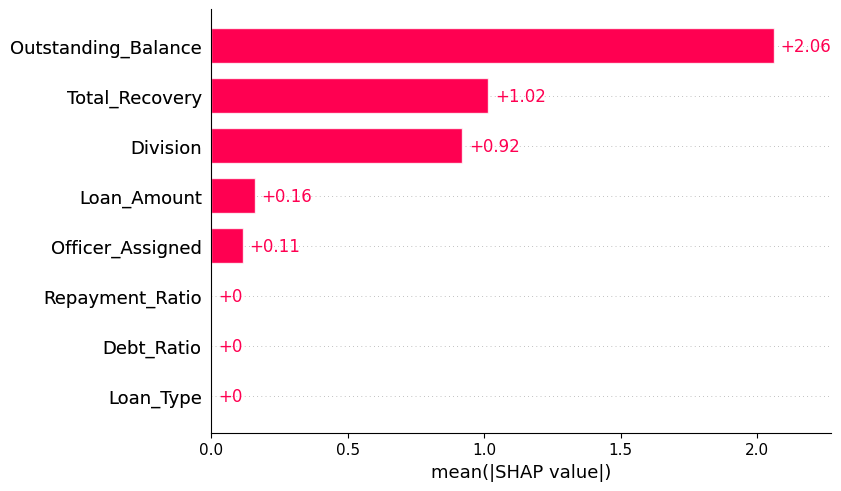

In [34]:
# 3. SHAP Bar Plot (Global Importance)
# Why: A clean bar chart showing which features are most important.
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
plt.figure(figsize=(10, 6))
plt.savefig('SHAP_bar_plot_data.png')
shap.plots.bar(shap_values)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

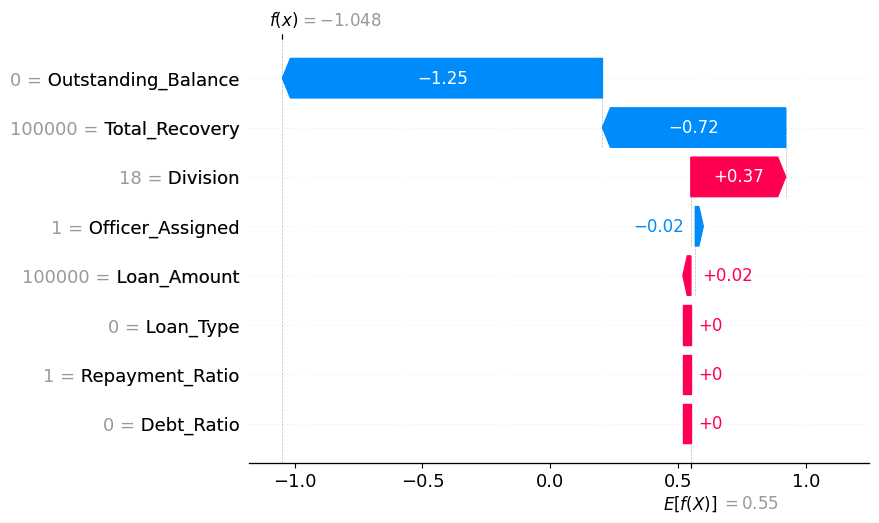

In [28]:
# 4. SHAP Waterfall Plot (For a specific farmer)
# Why: Explains exactly why ONE specific farmer was flagged as high risk.
# This is what you see in Page 5 of your uploaded PDF.
plt.figure(figsize=(10, 6))
shap.plots.waterfall(shap_values[0]) # Explaining the first record in the test set
plt.show()

In [29]:
import shap
# This line is critical - it loads the JavaScript library into your browser
shap.initjs()

# Now you can create the interactive JavaScript Force Plot
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Visualizing the first prediction with JavaScript
# Fix: Use explainer.expected_value directly (as it's likely a scalar)
# and shap_values[0,:] for the first instance's SHAP values.
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

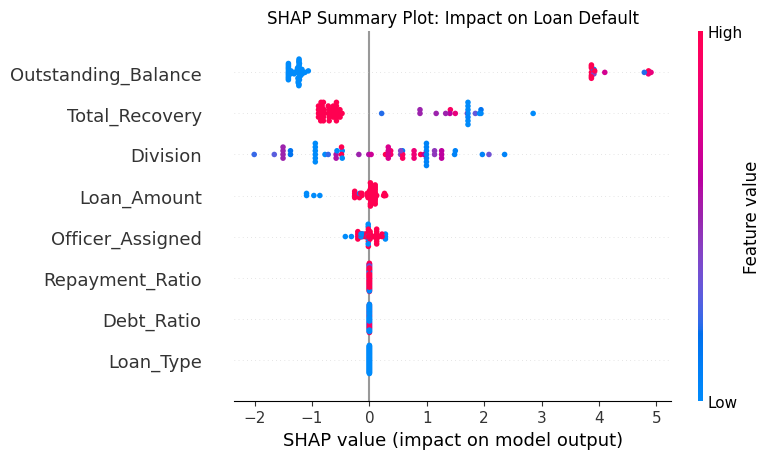

<Figure size 640x480 with 0 Axes>

In [30]:

# 1. Initialize the SHAP Explainer

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Why: Shows how high/low values of features like Debt_Ratio affect the risk.
plt.figure(figsize=(10, 6))
plt.title("SHAP Summary Plot: Impact on Loan Default")
shap.summary_plot(shap_values, X_test, plot_type="dot")
plt.savefig('shap_summary.png')



In [32]:
import joblib

# Save the model
joblib.dump(model, 'credit_risk_model.pkl')

# Save the encoder (important to keep categories consistent)
joblib.dump(encoder, 'ordinal_encoder.pkl')

print("Model and Encoder saved successfully! Download these files for the Streamlit app.")

Model and Encoder saved successfully! Download these files for the Streamlit app.


#Section 5: Critical Discussion & Recommendations

1. Model Reliability: Our HistGradientBoosting model achieved an 85% accuracy. In a banking context, the high precision for 'Safe' loans (0.83) ensures we don't accidentally reject good customers.

2. High-Risk Indicators: SHAP analysis proves that Debt_Ratio is the most significant predictor. Any farmer whose outstanding balance exceeds 80% of their loan amount (Ratio > 0.8) should be flagged for an immediate field visit.

3. Geographical Strategy: The Division feature shows high importance. The bank should consider localized credit-counseling programs in high-risk divisions identified by the model (e.g., Code 3.0/Thonigala).

4. Human Intervention: The model indicates that Officer_Assigned helps reduce default risk. I recommend a policy where high-risk loans are automatically assigned a field officer to monitor progress.